## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
#clear all variables
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import cv2
import glob
import importlib
import matplotlib.pyplot as plt
from gen_cam_cal import *
from gen_process_image import *
from gen_linefit import *
from gen_stats_display import *
from gen_detection_pipeline import *

%matplotlib inline

## Camera Calibration using chessboard images

In [3]:
# Make a list of calibration images
images = glob.glob('../cal_images/calibration*.jpg')

# Calibrate camera and apply distortion matrix to test images
mtx, dist = cal_cam(images)

## Undistort chessboard images using the distortion matrix

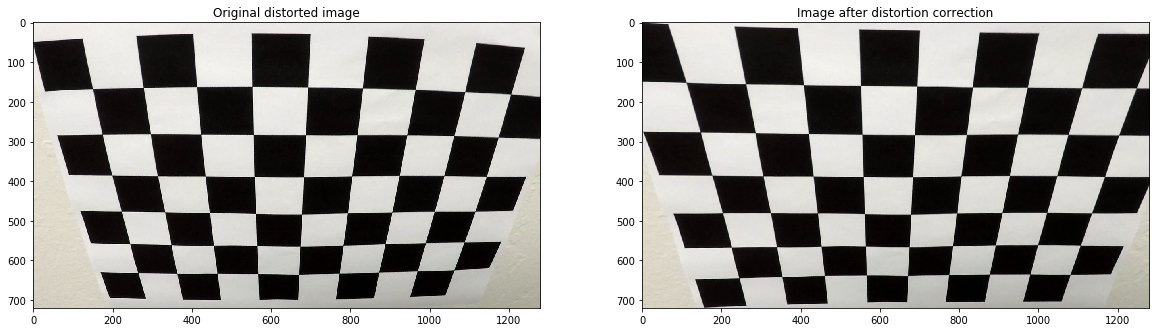

In [4]:
testfname = '../cal_images/calibration2.jpg'
test_img = cv2.imread(testfname)

dst = undistort_image(test_img, mtx, dist)

plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('Original distorted image')
plt.imshow(test_img[:,:,::-1])
plt.subplot(1,2,2)
plt.title('Image after distortion correction')
plt.imshow(dst[:,:,::-1])

## Undistort a road image

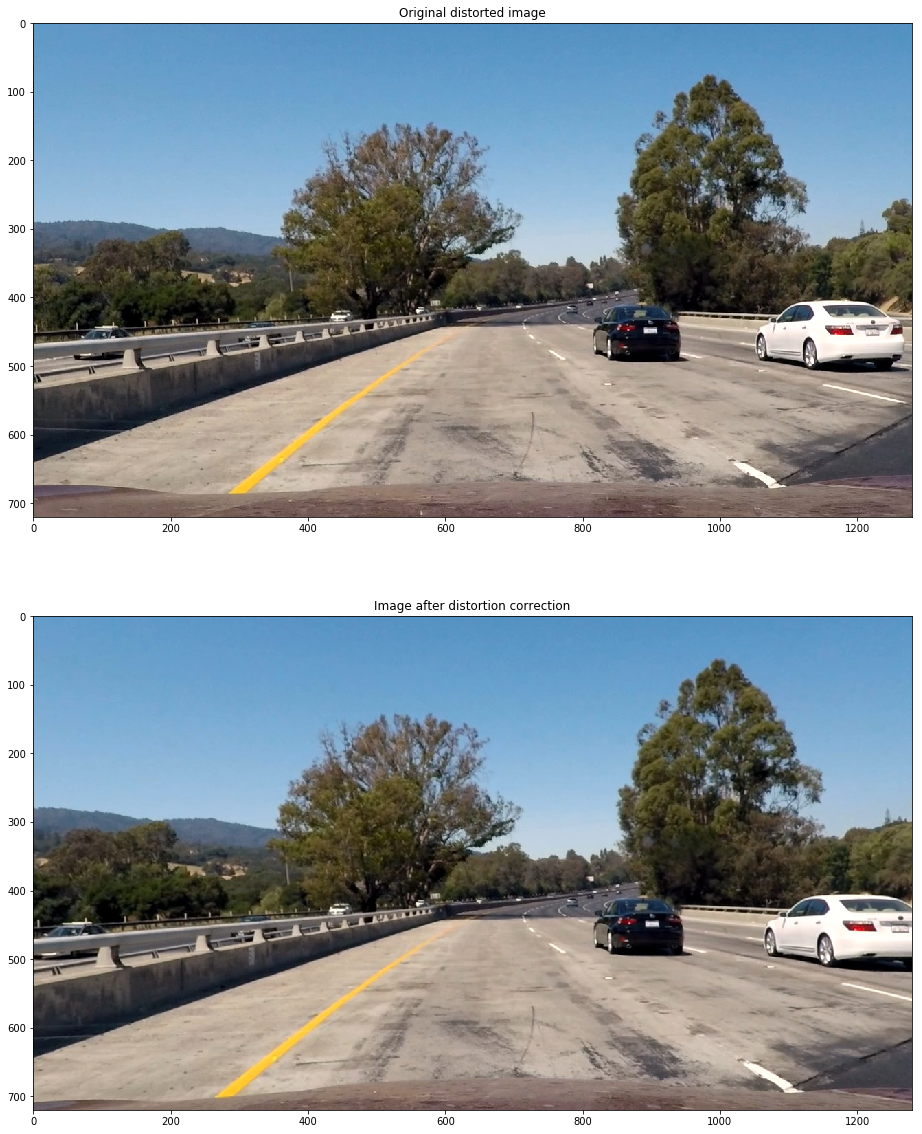

In [5]:
testfname = '../test_images/test1.jpg'
test_img = cv2.imread(testfname)

dst = undistort_image(test_img, mtx, dist)

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.title('Original distorted image')
plt.imshow(test_img[:,:,::-1])
plt.subplot(2,1,2)
plt.title('Image after distortion correction')
plt.imshow(dst[:,:,::-1])

## Apply thresholding 
Binary thresholding on Sobel gradient, Sobel Mag and dir, and S-channel Color  

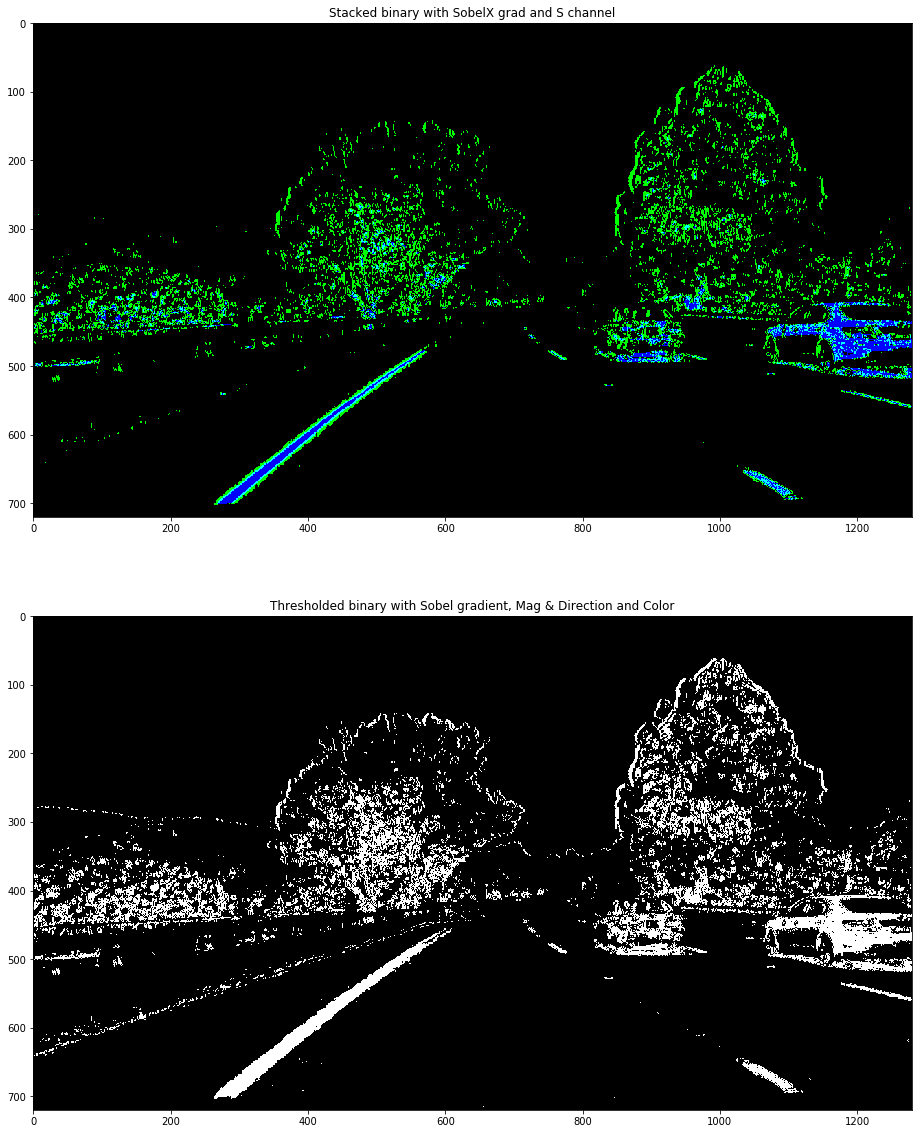

In [6]:
#Run the pipeline
result_color_bin, result_combined_bin = bin_threshold_pipeline(dst)

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.title('Stacked binary with SobelX grad and S channel')
plt.imshow(result_color_bin)
plt.subplot(2,1,2)
plt.title('Thresholded binary with Sobel gradient, Mag & Direction and Color')
plt.imshow(result_combined_bin,cmap='gray')

## Perspective transform

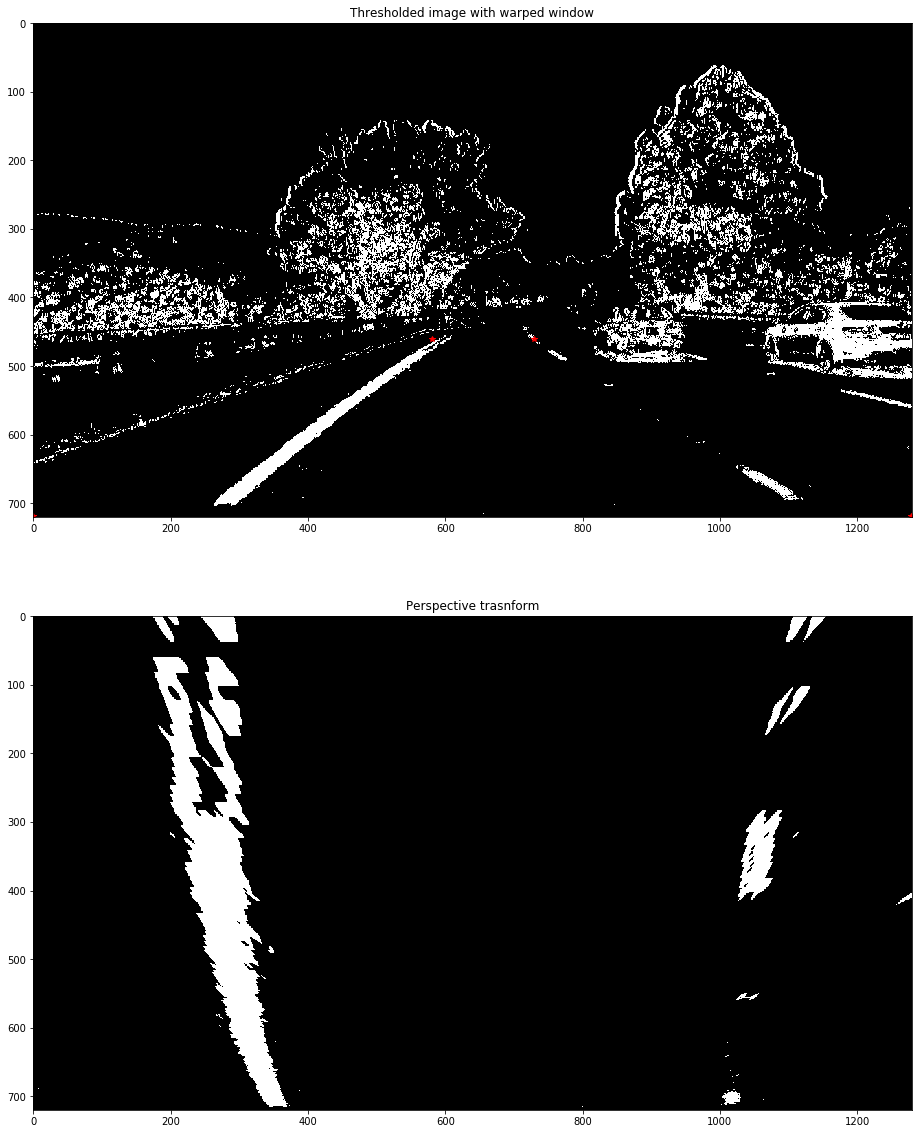

In [7]:
src_rect = np.float32(
    [[580, 460],
    [735, 460],
    [-100, 720],
    [1380, 720]])
    
dst_rect = np.float32(
    [[100, 0],
    [1180,0],
    [100, 720],
    [1180, 720]])

warped_img, Minv = warp(result_combined_bin, src_rect, dst_rect)

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.title('Thresholded image with warped window')
plt.imshow(result_combined_bin, cmap='gray')
plt.plot(580,460,'r*')
plt.plot(730,460,'r*')
plt.plot(0,719,'r*')
plt.plot(1279,719,'r*')

plt.subplot(2,1,2)
plt.title('Perspective trasnform')
plt.imshow(warped_img, cmap='gray')

## Detect lanes and curve fit
    1) Detect using histogram to initiate search and then windowing 
    2) Curve Fit
    3) Error checking and correction
        * Check if road width is within expected range; apply correction if not
        * Apply correction if 3 windows from either end of the image are empty, polyfit does not do a good job 

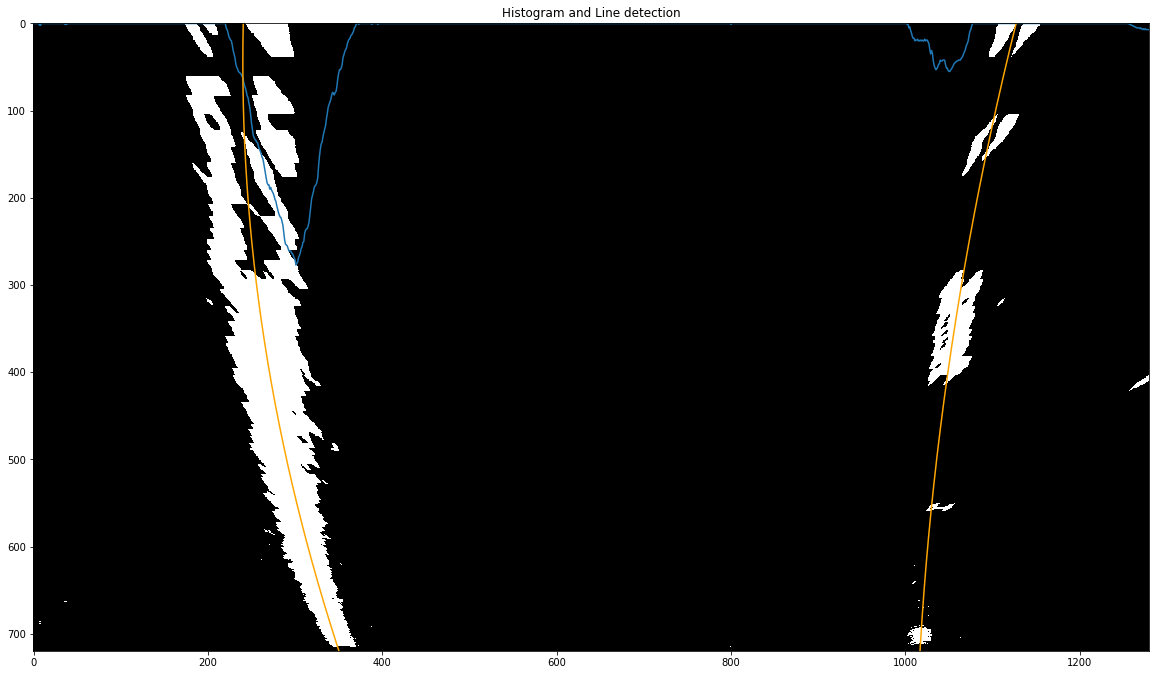

In [8]:
histogram = np.sum(warped_img[int(warped_img.shape[0]/2):,:], axis=0)

frame_no = 1
avg_road_width = 0

polyfit_img,left_fitx,right_fitx,ploty,adjust_bool,curr_road_width = poly_fit_rimage(warped_img, frame_no, avg_road_width)

plt.figure(figsize=(20,20))
plt.plot(histogram)
plt.imshow(warped_img, cmap='gray')
plt.title('Histogram and Line detection')
plt.plot(left_fitx, ploty, color='orange')
plt.plot(right_fitx, ploty, color='orange')


## Image pipeline with curvate and offset
Run a sample image through the full pipeline

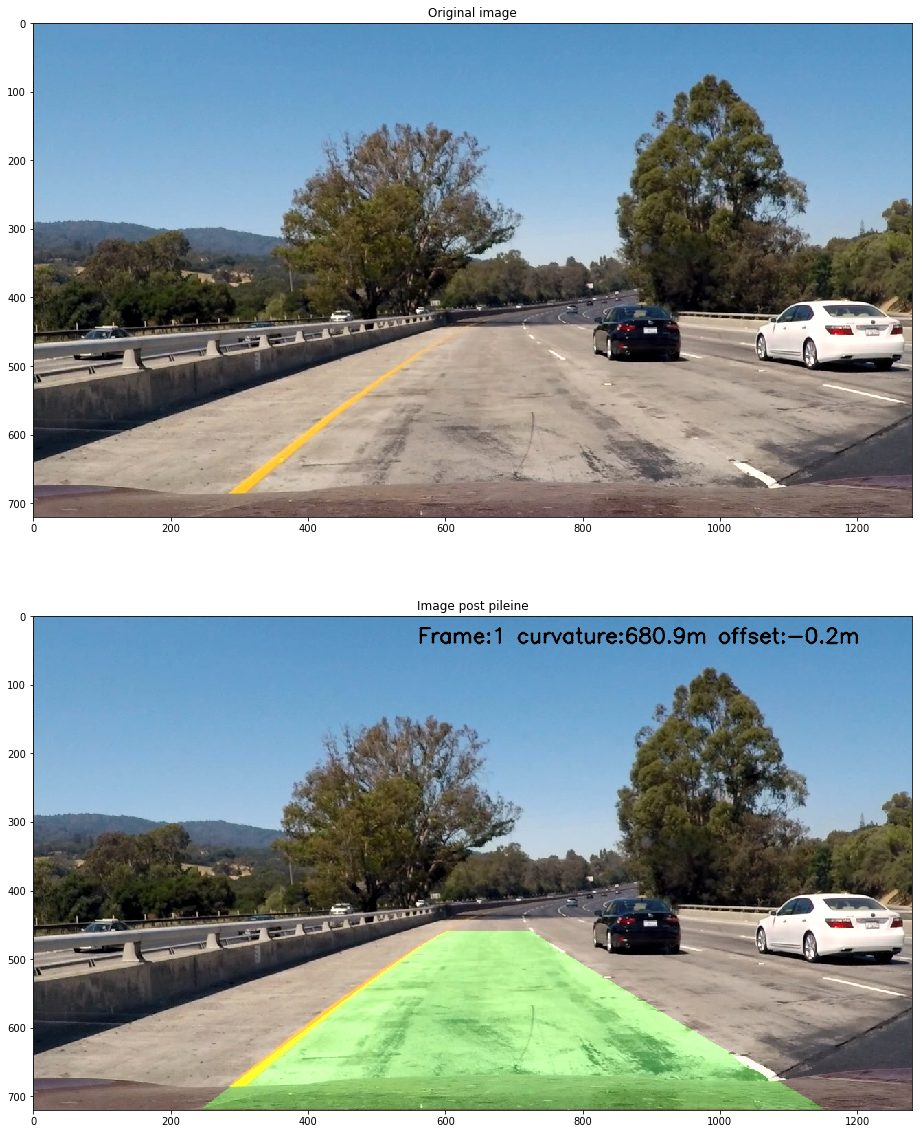

In [9]:
testfname = '../test_images/test1.jpg'
test_pipeline_img = cv2.imread(testfname)

frame_no = 1
avg_road_width = 0
out_image, road_width = img_pipeline(test_pipeline_img, mtx,dist, src_rect, dst_rect, frame_no, avg_road_width)

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.title('Original image')
plt.imshow(test_pipeline_img[:,:,::-1])
plt.subplot(2,1,2)
plt.title('Image post pileine')
plt.imshow(out_image[:,:,::-1])

## Process Video

In [10]:
# Import everything needed to edit/save/watch video clips
import moviepy
from moviepy.editor import *
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
# Make a list of calibration images
images = glob.glob('../cal_images/calibration*.jpg')

# Calibrate camera and apply distortion matrix to test images
mtx, dist = cal_cam(images)

In [12]:
adv_lanes_output = './adv_lane_track.mp4'

clip = VideoFileClip('../output_video/project_video.mp4')

output_frames = []
frame_no = 1
avg_road_width = 0

for frame in clip.iter_frames():
    out_image, road_width = img_pipeline(frame, mtx,dist, src_rect, dst_rect, frame_no, avg_road_width)
    avg_road_width = road_width
    frame_no = frame_no + 1
    output_frames.append(out_image)
    
lanes_output_clip = ImageSequenceClip(output_frames, fps=clip.fps)
%time lanes_output_clip.write_videofile(adv_lanes_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(adv_lanes_output))

[MoviePy] >>>> Building video ./adv_lane_track.mp4
[MoviePy] Writing video ./adv_lane_track.mp4


100%|██████████| 1260/1260 [01:11<00:00, 17.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./adv_lane_track.mp4 

CPU times: user 3.39 s, sys: 13.4 s, total: 16.8 s
Wall time: 1min 13s
